# 계층적 에이전트 팀

이 튜토리얼에서는 **계층적 에이전트 팀**을 구성하는 방법을 살펴봅니다.

단일 에이전트나 단일 수준의 감독자(supervisor)로는 대응하기 힘든 복잡한 작업을 **계층적 구조**를 통해 분할하고, 각각의 하위 수준 감독자(supervisor)가 해당 영역에 특화된 작업자(Worker) 에이전트를 관리하는 방식을 구현합니다.

이러한 계층적 접근 방식은 작업자가 너무 많아질 경우나, 단일 작업자가 처리하기 힘든 복잡한 작업을 효율적으로 해결하는 데 도움이 됩니다.  

본 예제는 [AutoGen 논문](https://arxiv.org/abs/2308.08155)의 아이디어를 LangGraph를 통해 구현한 사례로, 웹 연구와 문서 작성이라는 두 가지 하위 작업을 서로 다른 팀으로 구성하고, 상위 및 중간 수준의 감독자를 통해 전체 프로세스를 관리하는 방법을 제시합니다.

![](./assets/langgraph-multi-agent-team-supervisor.png)

---

**왜 계층적 에이전트 팀인가?**

이전 Supervisor 예제에서는 하나의 supervisor node가 여러 작업자 노드에게 작업을 할당하고 결과를 취합하는 과정을 살펴보았습니다. 이 방식은 간단한 경우에 효율적입니다. 그러나 다음과 같은 상황에서는 계층적 구조가 필요할 수 있습니다.

- **작업 복잡성 증가**: 단일 supervisor로는 한 번에 처리할 수 없는 다양한 하위 영역의 전문 지식이 필요할 수 있습니다.
- **작업자 수 증가**: 많은 수의 작업자를 관리할 때, 단일 supervisor가 모든 작업자에게 직접 명령을 내리면 관리 부담이 커집니다.

이러한 상황에서 상위 수준의 supervisor는 하위 수준의 **sub-supervisor** 들에게 작업을 할당하고, 각 **sub-supervisor** 는 해당 작업을 전문화된 작업자 팀에 재할당하는 계층적 구조를 구성할 수 있습니다.

---

**이 튜토리얼에서 다룰 내용**

1. **도구 생성**: 웹 연구(Web Research) 및 문서 작성(Documentation)을 위한 에이전트 도구 정의    
2. **에이전트 팀 정의**: 연구 팀 및 문서 작성 팀을 계층적으로 정의하고 구성  
3. **계층 추가**: 상위 수준 그래프와 중간 수준 감독자를 통해 전체 작업을 계층적으로 조정  
4. **결합**: 모든 요소를 통합하여 최종적인 계층적 에이전트 팀 구축

---

**참고**

- [AutoGen 논문: Enabling Next-Gen LLM Applications via Multi-Agent Conversation (Wu et al.)](https://arxiv.org/abs/2308.08155)
- [LangGraph - Multi-Agent 개념](https://langchain-ai.github.io/langgraph/concepts/multi_agent/)

## 환경 설정

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Use-Cases")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Use-Cases


In [3]:
from langchain_teddynote.models import get_model_name, LLMs

# 최신 모델 이름 가져오기
MODEL_NAME = get_model_name(LLMs.GPT4o)
print(MODEL_NAME)

gpt-4o


## 도구 생성

각 팀은 하나 이상의 에이전트로 구성되며, 각 에이전트는 하나 이상의 도구를 갖추게 됩니다. 아래에서는 다양한 팀에서 사용할 모든 도구를 정의합니다.

먼저 연구 팀을 살펴보겠습니다.

**ResearchTeam 도구**

ResearchTeam은 웹에서 정보를 찾기 위해 검색 엔진과 URL 스크래퍼를 사용할 수 있습니다. ResearchTeam의 성능을 향상시키기 위해 추가 기능을 아래에 자유롭게 추가할 수 있습니다.

In [4]:
from typing import List
from langchain_community.document_loaders import WebBaseLoader
from langchain_teddynote.tools.tavily import TavilySearch
from langchain_core.tools import tool

# 검색 도구 정의(TavilySearch)
tavily_tool = TavilySearch(max_results=5)


# 웹 페이지에서 세부 정보를 스크래핑하기 위한 도구 정의
@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    # 주어진 URL 목록을 사용하여 웹 페이지 로드
    loader = WebBaseLoader(
        web_path=urls,
        header_template={
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36",
        },
    )
    docs = loader.load()

    # 로드된 문서의 제목과 내용을 포함한 문자열 생성
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

USER_AGENT environment variable not set, consider setting it to identify your requests.


**문서 작성 팀 도구**

다음으로, 문서 작성 팀이 사용할 도구(파일 접근 도구)를 정의합니다. 

이 도구는 에이전트가 파일 시스템에 접근할 수 있도록 하며, 이는 안전하지 않을 수 있습니다. 따라서, 사용에 주의가 필요합니다.

In [5]:
from pathlib import Path
from typing import Dict, Optional, List
from typing_extensions import Annotated


# 임시 디렉토리 생성 및 작업 디렉토리 설정
WORKING_DIRECTORY = Path("./tmp")

# tmp 폴더가 없으면 생성
WORKING_DIRECTORY.mkdir(exist_ok=True)


# 아웃라인 생성 및 파일로 저장
@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    # 주어진 파일 이름으로 아웃라인을 저장
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


# 문서 읽기
@tool
def read_document(
    file_name: Annotated[str, "File path to read the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    # 주어진 파일 이름으로 문서 읽기
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    # 시작 줄이 지정되지 않은 경우 기본값 설정
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


# 문서 쓰기 및 저장
@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    # 주어진 파일 이름으로 문서 저장
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


# 문서 편집
@tool
def edit_document(
    file_name: Annotated[str, "File path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "File path of the edited document."]:
    """Edit a document by inserting text at specific line numbers."""

    # 주어진 파일 이름으로 문서 읽기
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    # 삽입할 텍스트를 정렬하여 처리
    sorted_inserts = sorted(inserts.items())

    # 지정된 줄 번호에 텍스트 삽입
    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    # 편집된 문서를 파일에 저장
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

다음은 코드 실행 도구인 `PythonREPLTool` 을 정의합니다.

In [6]:
from langchain_experimental.tools import PythonREPLTool

# PythonREPL 도구
python_repl_tool = PythonREPLTool()

## 다중 에이전트 생성을 위한 유틸리티 함수 정의

다음은 작업을 간결하게 수행하기 위한 몇 가지 유틸리티 함수를 생성하는 방법입니다.

이때 이전 튜토리얼에서 다룬 `functools.partial` 함수를 사용하여 에이전트 노드를 생성합니다.

1. `worker agent` 생성.
2. `sub-graph`의 `supervisor` 생성.

In [7]:
from langgraph.graph import START, END
from langchain_core.messages import HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent


# 에이전트 팩토리 클래스
class AgentFactory:
    def __init__(self, model_name):
        self.llm = ChatOpenAI(model=model_name, temperature=0)

    def create_agent_node(self, agent, name: str):
        # 노드 생성 함수
        def agent_node(state):
            result = agent.invoke(state)
            return {
                "messages": [
                    HumanMessage(content=result["messages"][-1].content, name=name)
                ]
            }

        return agent_node


# LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# Agent Factory 인스턴스 생성
agent_factory = AgentFactory(MODEL_NAME)

아래는 `AgentFactory` 를 사용하여 에이전트 노드를 생성하는 예시입니다.

예시에서는 검색 에이전트를 생성하는 방법을 살펴보겠습니다.

In [8]:
# 에이전트 정의
search_agent = create_react_agent(llm, tools=[tavily_tool])
# 에이전트 노드 생성
search_node = agent_factory.create_agent_node(search_agent, name="Searcher")

다음은 팀 감독자(Team Supervisor)를 생성하는 함수입니다.

In [9]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal


def create_team_supervisor(model_name, system_prompt, members) -> str:
    # 다음 작업자 선택 옵션 목록 정의
    options_for_next = ["FINISH"] + members

    # 작업자 선택 응답 모델 정의: 다음 작업자를 선택하거나 작업 완료를 나타냄
    class RouteResponse(BaseModel):
        next: Literal[*options_for_next]

    # ChatPromptTemplate 생성
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next? "
                "Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options_for_next))

    # LLM 초기화
    llm = ChatOpenAI(model=model_name, temperature=0)

    # 프롬프트와 LLM을 결합하여 체인 구성
    supervisor_chain = prompt | llm.with_structured_output(RouteResponse)

    return supervisor_chain

## 에이전트 팀 정의

연구 팀(Research Team)과 문서 작성 팀(Doc Writing Team)을 정의합니다.

### 연구 팀(Research Team)

연구 팀은 `search agent`와 `web scraping`을 담당하는 `research_agent`라는 두 개의 작업자 노드를 가집니다. 이들을 생성하고 팀 감독자도 설정해 보겠습니다.

In [10]:
import operator
from typing import List, TypedDict
from typing_extensions import Annotated

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent


# 상태 정의
class ResearchState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]  # 메시지
    team_members: List[str]  # 멤버 에이전트 목록
    next: str  # Supervisor 에이전트에게 다음 작업자를 선택하도록 지시


# LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# 검색 노드 생성
search_agent = create_react_agent(llm, tools=[tavily_tool])
search_node = agent_factory.create_agent_node(search_agent, name="Searcher")

# 웹 스크래핑 노드 생성
web_scraping_agent = create_react_agent(llm, tools=[scrape_webpages])
web_scraping_node = agent_factory.create_agent_node(
    web_scraping_agent, name="WebScraper"
)

# Supervisor 에이전트 생성
supervisor_agent = create_team_supervisor(
    MODEL_NAME,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers: Search, WebScraper. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Searcher", "WebScraper"],
)

다음으로 라우팅할 노드를 선택하는 함수를 정의합니다.

In [11]:
def get_next_node(x):
    return x["next"]

### Research Team 그래프 생성

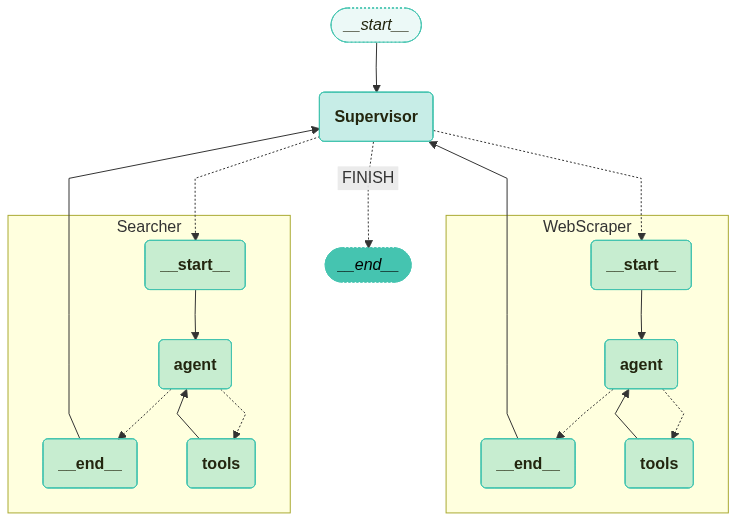

In [12]:
from langchain_teddynote.graphs import visualize_graph
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
web_research_graph = StateGraph(ResearchState)

# 노드 추가
web_research_graph.add_node("Searcher", search_node)
web_research_graph.add_node("WebScraper", web_scraping_node)
web_research_graph.add_node("Supervisor", supervisor_agent)

# 엣지 추가
web_research_graph.add_edge("Searcher", "Supervisor")
web_research_graph.add_edge("WebScraper", "Supervisor")

# 조건부 엣지 정의: Supervisor 노드의 결정에 따라 다음 노드로 이동
web_research_graph.add_conditional_edges(
    "Supervisor",
    get_next_node,
    {"Searcher": "Searcher", "WebScraper": "WebScraper", "FINISH": END},
)

# 시작 노드 설정
web_research_graph.set_entry_point("Supervisor")

# 그래프 컴파일
web_research_app = web_research_graph.compile(checkpointer=MemorySaver())

# 그래프 시각화
visualize_graph(web_research_app, xray=True)

`web_research_app` 을 실행합니다.

In [14]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, invoke_graph


def run_graph(app, message: str, recursive_limit: int = 50):
    # config 설정(재귀 최대 횟수, thread_id)
    config = RunnableConfig(
        recursion_limit=recursive_limit, configurable={"thread_id": random_uuid()}
    )

    # 질문 입력
    inputs = {
        "messages": [HumanMessage(content=message)],
    }

    # 그래프 실행
    invoke_graph(app, inputs, config)

    return app.get_state(config).values

In [15]:
output = run_graph(
    web_research_app,
    "https://finance.naver.com/news 의 주요 뉴스 정리해서 출력해줘. 출처(URL) 도 함께 출력해줘.",
)


🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
WebScraper

🔄 Node: agent in [WebScraper] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  scrape_webpages (call_3aMvVqTesy20dFA2vDdULTVR)
 Call ID: call_3aMvVqTesy20dFA2vDdULTVR
  Args:
    urls: ['https://finance.naver.com/news']

🔄 Node: tools in [WebScraper] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: scrape_webpages

<Document name="네이버페이 증권">



네이버페이 증권



































메인 메뉴로 바로가기
본문으로 바로가기










네이버





페이






증권






증권 종목명·지수명 검색







검색


자동완성







@code@
@txt@
@market@

@full_txt@
@in_code@
@in_name@
@in_link@
@in_market@




												공모주와 해외 종목은 모바일 페이지로 이동합니다.
											








												현재 자동완성 기능을 사용하고 계십니다.
											









												자동완성 기능이 활성화되었습니다.
				

In [16]:
# 최종 결과 출력
print(output["messages"][-1].content)

Here are the major news highlights from the Naver Finance news page:

1. **'年 80% 분배율'이라 샀는데…美 증시 급락에 '초고배당' ETF 주의보**  
   Source: [한국경제](https://finance.naver.com/news)

2. **올해 상승분 모조리 내준 비트코인, 대응 전략은?[엠블록레터]**  
   Source: [매일경제](https://finance.naver.com/news)

3. **"흔들릴 때 더 산다"…SK하이닉스에 '250억' 베팅한 개미들**  
   Source: [한국경제](https://finance.naver.com/news)

4. **엠플러스, CB 조기상환·매입 소각으로 전환사채 오버행 해소**  
   Source: [머니투데이](https://finance.naver.com/news)

5. **쌍방울, 정리매매 개시 첫날 67% 폭락 [이런국장 저런주식]**  
   Source: [서울경제](https://finance.naver.com/news)

6. **외국인 떠나는 자리에 ‘동학개미’ 등판… 코스피 3920선 회복**  
   Source: [조선비즈](https://finance.naver.com/news)

For more details, you can visit the [Naver Finance News page](https://finance.naver.com/news).


### 문서 작성 팀(Doc Writing Team)

이번에는 문서 작성 팀을 생성합니다. 이때, 각 agent에게 서로 다른 file-writing 도구에 대한 접근 권한을 부여합니다. 

In [17]:
import operator
from typing import List, TypedDict, Annotated
from pathlib import Path


# 임시 디렉토리 생성 및 작업 디렉토리 설정
WORKING_DIRECTORY = Path("./tmp")
WORKING_DIRECTORY.mkdir(exist_ok=True)  # tmp 폴더가 없으면 생성


# 상태 정의
class DocWritingState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: str
    next: str
    current_files: str  # 현재 작업중인 파일


# 상태 전처리 노드: 각각의 에이전트가 현재 작업 디렉토리의 상태를 더 잘 인식할 수 있도록 함
def preprocess(state):
    # 작성된 파일 목록 초기화
    written_files = []

    try:
        # 작업 디렉토리 내의 모든 파일을 검색하여 상대 경로로 변환
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except Exception:
        pass
    # 작성된 파일이 없으면 상태에 "No files written." 추가
    if not written_files:
        return {**state, "current_files": "No files written."}

    # 작성된 파일 목록을 상태에 추가
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }


# LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME)

# 문서 작성 에이전트 생성
doc_writer_agent = create_react_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    state_modifier="You are a arxiv researcher. Your mission is to write arxiv style paper on given topic/resources.",
)
context_aware_doc_writer_agent = preprocess | doc_writer_agent
doc_writing_node = agent_factory.create_agent_node(
    context_aware_doc_writer_agent, name="DocWriter"
)

# 노트 작성 노드
note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    state_modifier="You are an expert in creating outlines for research papers. Your mission is to create an outline for a given topic/resources or documents.",
)
context_aware_note_taking_agent = preprocess | note_taking_agent
note_taking_node = agent_factory.create_agent_node(
    context_aware_note_taking_agent, name="NoteTaker"
)


# 차트 생성 에이전트 생성
chart_generating_agent = create_react_agent(
    llm, tools=[read_document, python_repl_tool]
)
context_aware_chart_generating_agent = preprocess | chart_generating_agent
chart_generating_node = agent_factory.create_agent_node(
    context_aware_chart_generating_agent, name="ChartGenerator"
)

# 문서 작성 팀 감독자 생성
doc_writing_supervisor = create_team_supervisor(
    MODEL_NAME,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  ['DocWriter', 'NoteTaker', 'ChartGenerator']. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["DocWriter", "NoteTaker", "ChartGenerator"],
)

### Doc Writing Team 그래프 생성

In [18]:
# 그래프 생성
authoring_graph = StateGraph(DocWritingState)

# 노드 정의
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("ChartGenerator", chart_generating_node)
authoring_graph.add_node("Supervisor", doc_writing_supervisor)

# 엣지 정의
authoring_graph.add_edge("DocWriter", "Supervisor")
authoring_graph.add_edge("NoteTaker", "Supervisor")
authoring_graph.add_edge("ChartGenerator", "Supervisor")

# 조건부 엣지 정의: Supervisor 노드의 결정에 따라 다음 노드로 이동
authoring_graph.add_conditional_edges(
    "Supervisor",
    get_next_node,
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "ChartGenerator": "ChartGenerator",
        "FINISH": END,
    },
)

# 시작 노드 설정
authoring_graph.set_entry_point("Supervisor")

# 그래프 컴파일
authoring_app = authoring_graph.compile(checkpointer=MemorySaver())

그래프를 시각화 합니다.

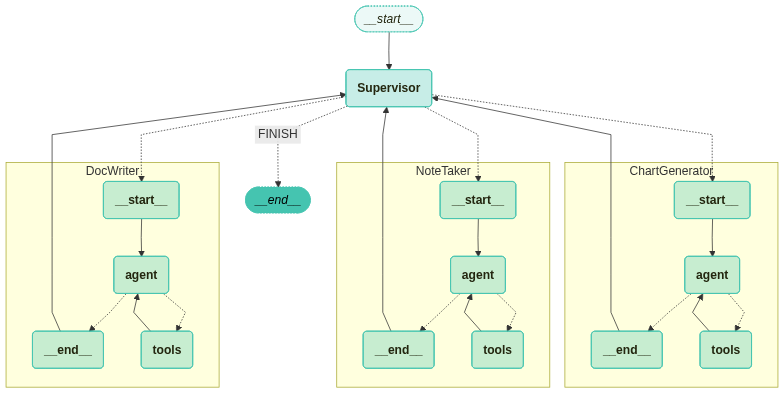

In [19]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(authoring_app, xray=True)

그래프를 실행하고 결과를 확인합니다.

In [20]:
output = run_graph(
    authoring_app,
    "Transformer 의 구조에 대해서 심층 파악해서 논문의 목차를 한글로 작성해줘. "
    "그 다음 각각의 목차에 대해서 5문장 이상 작성해줘. "
    "상세내용 작성시 만약 chart 가 필요하면 차트를 작성해줘. "
    "최종 결과를 저장해줘. ",
)


🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
DocWriter

🔄 Node: agent in [DocWriter] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  write_document (call_d23gW7KJKpiXyHJ7OG04GOLk)
 Call ID: call_d23gW7KJKpiXyHJ7OG04GOLk
  Args:
    content: # 트랜스포머 구조에 대한 논문 목차

## 1. 서론

## 2. 트랜스포머의 배경 이론

### 2.1 자연어 처리의 발전
### 2.2 딥러닝과 신경망의 발전

## 3. 트랜스포머의 구성 요소

### 3.1 인코더와 디코더
### 3.2 어텐션 메커니즘
### 3.3 포지셔널 인코딩

## 4. 트랜스포머의 작동 원리

### 4.1 셀프 어텐션과 멀티 헤드 어텐션
### 4.2 인코더-디코더 상호작용

## 5. 트랜스포머의 장점과 응용

### 5.1 성능 향상과 효율성
### 5.2 실제 사례와 응용 분야

## 6. 결론

## 7. 참고문헌
    file_name: transformer_structure_paper_outline.txt

🔄 Node: tools in [DocWriter] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: write_document

Document saved to transformer_structure_paper_outline.txt

🔄 Node: a

## Super-Graph 생성

이 설계에서는 **상향식 계획 정책**을 적용하고 있습니다. 이미 두 개의 그래프를 생성했지만, 이들 간의 작업을 어떻게 라우팅할지 결정해야 합니다.

이를 위해 **Super Graph**를 정의하여 이전 두 그래프를 조정하고, 이 상위 수준 상태가 서로 다른 그래프 간에 어떻게 공유되는지를 정의하는 연결 요소를 추가할 것입니다.

먼저, 총 감독자 노드를 생성합니다.

In [21]:
from langchain_core.messages import BaseMessage
from langchain_openai.chat_models import ChatOpenAI

# 기본 LLM으로 ChatOpenAI 인스턴스 생성
llm = ChatOpenAI(model=MODEL_NAME)

# 팀 감독자 노드 생성
supervisor_node = create_team_supervisor(
    MODEL_NAME,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: ['ResearchTeam', 'PaperWritingTeam']. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["ResearchTeam", "PaperWritingTeam"],
)

다음은 Super-Graph의 상태와 노드를 정의 합니다.

Super-Graph 는 단순하게 Task 를 라우팅 하는 역할이 주를 이룹니다.

In [22]:
from typing import TypedDict, List, Annotated
import operator


# 상태 정의
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    # 라우팅 결정
    next: str


# 마지막 메시지 반환 노드
def get_last_message(state: State) -> str:
    last_message = state["messages"][-1]
    if isinstance(last_message, str):
        return {"messages": [HumanMessage(content=last_message)]}
    else:
        return {"messages": [last_message.content]}


# 응답 종합 노드
def join_graph(response: dict):
    # 마지막 메시지를 추출하여 메시지 목록으로 반환
    return {"messages": [response["messages"][-1]]}

### Super-Graph 정의

이제 2개의 팀을 연결하는 Super-Graph를 정의합니다.

In [23]:
# 그래프 정의
super_graph = StateGraph(State)

# 노드 정의
super_graph.add_node("ResearchTeam", get_last_message | web_research_app | join_graph)
super_graph.add_node("PaperWritingTeam", get_last_message | authoring_app | join_graph)
super_graph.add_node("Supervisor", supervisor_node)

# 엣지 정의
super_graph.add_edge("ResearchTeam", "Supervisor")
super_graph.add_edge("PaperWritingTeam", "Supervisor")

# 조건부 엣지 추가: Supervisor 의 결정에 따라 다음 노드로 이동
super_graph.add_conditional_edges(
    "Supervisor",
    get_next_node,
    {
        "PaperWritingTeam": "PaperWritingTeam",
        "ResearchTeam": "ResearchTeam",
        "FINISH": END,
    },
)

# Supervisor 노드를 시작 노드로 설정
super_graph.set_entry_point("Supervisor")

# 그래프 컴파일
super_graph = super_graph.compile(checkpointer=MemorySaver())

그래프를 시각화 합니다.

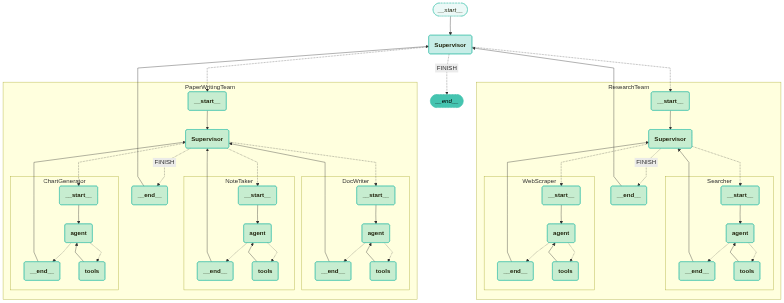

In [24]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(super_graph, xray=True)

In [25]:
output = run_graph(
    super_graph,
    """주제: multi-agent 구조를 사용하여 복잡한 작업을 수행하는 방법

상세 가이드라인:  
- 주제에 대한 Arxiv 논문 형식의 리포트 생성
- Outline 생성
- 각각의 Outline 에 대해서 5문장 이상 작성
- 상세내용 작성시 만약 chart 가 필요하면 차트 생성 및 추가
- 한글로 리포트 작성
- 출처는 APA 형식으로 작성
- 최종 결과는 .md 파일로 저장""",
    recursive_limit=150,
)


🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
ResearchTeam

🔄 Node: Supervisor in [ResearchTeam] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
Searcher

🔄 Node: agent in [Searcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

## Arxiv 논문 형식 리포트: Multi-Agent 구조를 사용하여 복잡한 작업을 수행하는 방법

### Outline

1. 서론
2. Multi-Agent 시스템의 개요
3. Multi-Agent 구조의 장점
4. 복잡한 작업에서의 Multi-Agent 시스템 적용 사례
5. Multi-Agent 시스템 설계 시 고려사항
6. 결론

---

### 1. 서론

Multi-Agent 시스템은 여러 개의 에이전트가 상호작용하여 복잡한 문제를 해결하는 구조를 의미합니다. 이러한 시스템은 각 에이전트가 독립적으로 작동하면서도 협력하여 목표를 달성할 수 있도록 설계됩니다. 최근 인공지능과 로봇공학의 발전으로 인해 Multi-Agent 시스템은 다양한 분야에서 주목받고 있습니다. 본 논문에서는 Multi-Agent 구조를 활용하여 복잡한 작업을 수행하는 방법에 대해 논의하고자 합니다. 이를 통해 Multi-Agent 시스템의 가능성과 한계를 이해하고, 향후 연구 방향을 제시합니다.

### 2. Multi-Agent 시스템의 개요

Multi-Agent 시스템은 여러 개의 독립적인 에이전트가 상호작용하여 문제를 해결하는 구조입니다. 각 에이전트는 자율적으로 행동하며, 특정 목표를 달성하기 위해 협력합니다. 이러한 시스템은 분

마크다운 형식으로 최종 결과물을 출력합니다.

In [26]:
from IPython.display import Markdown

if hasattr(output["messages"][-1], "content"):
    display(Markdown(output["messages"][-1].content))
else:
    display(Markdown(output["messages"][-1]))

위의 내용을 바탕으로 .md 파일을 생성하겠습니다.

```markdown
# Arxiv 논문 형식 리포트: Multi-Agent 구조를 사용하여 복잡한 작업을 수행하는 방법

## Outline

1. 서론
2. Multi-Agent 시스템의 개요
3. Multi-Agent 구조의 장점
4. 복잡한 작업에서의 Multi-Agent 시스템 적용 사례
5. Multi-Agent 시스템 설계 시 고려사항
6. 결론

---

## 1. 서론

Multi-Agent 시스템은 여러 개의 에이전트가 상호작용하여 복잡한 문제를 해결하는 구조를 의미합니다. 이러한 시스템은 각 에이전트가 독립적으로 작동하면서도 협력하여 목표를 달성할 수 있도록 설계됩니다. 최근 인공지능과 로봇공학의 발전으로 인해 Multi-Agent 시스템은 다양한 분야에서 주목받고 있습니다. 본 논문에서는 Multi-Agent 구조를 활용하여 복잡한 작업을 수행하는 방법에 대해 논의하고자 합니다. 이를 통해 Multi-Agent 시스템의 가능성과 한계를 이해하고, 향후 연구 방향을 제시합니다.

## 2. Multi-Agent 시스템의 개요

Multi-Agent 시스템은 여러 개의 독립적인 에이전트가 상호작용하여 문제를 해결하는 구조입니다. 각 에이전트는 자율적으로 행동하며, 특정 목표를 달성하기 위해 협력합니다. 이러한 시스템은 분산된 문제 해결, 자원 관리, 복잡한 환경에서의 의사결정 등에 유용합니다. Multi-Agent 시스템은 주로 분산 인공지능(Distributed Artificial Intelligence, DAI) 분야에서 연구되며, 다양한 알고리즘과 프로토콜이 개발되고 있습니다. 본 장에서는 Multi-Agent 시스템의 기본 개념과 작동 원리에 대해 설명합니다.

## 3. Multi-Agent 구조의 장점

Multi-Agent 구조는 여러 가지 장점을 제공합니다. 첫째, 시스템의 유연성과 확장성이 뛰어납니다. 새로운 에이전트를 추가하거나 기존 에이전트를 제거하는 것이 용이합니다. 둘째, 복잡한 문제를 분할하여 해결할 수 있어 효율성이 높습니다. 셋째, 시스템의 신뢰성과 견고성이 향상됩니다. 하나의 에이전트가 실패하더라도 전체 시스템에 미치는 영향이 최소화됩니다. 마지막으로, 다양한 분야에 적용 가능하여 응용 범위가 넓습니다.

## 4. 복잡한 작업에서의 Multi-Agent 시스템 적용 사례

Multi-Agent 시스템은 다양한 분야에서 복잡한 작업을 수행하는 데 활용됩니다. 예를 들어, 물류 및 공급망 관리에서 여러 로봇이 협력하여 물품을 운반하고 분류하는 작업에 사용됩니다. 또한, 금융 분야에서는 여러 에이전트가 시장 데이터를 분석하여 투자 결정을 내리는 데 기여합니다. 스마트 시티에서는 교통 관리, 에너지 분배 등 다양한 분야에서 Multi-Agent 시스템이 적용됩니다. 이러한 사례들은 Multi-Agent 시스템의 실용성과 효율성을 잘 보여줍니다.

## 5. Multi-Agent 시스템 설계 시 고려사항

Multi-Agent 시스템을 설계할 때는 여러 가지 요소를 고려해야 합니다. 첫째, 에이전트 간의 통신 프로토콜을 명확히 정의해야 합니다. 둘째, 각 에이전트의 역할과 책임을 명확히 구분해야 합니다. 셋째, 시스템의 안정성과 신뢰성을 보장하기 위한 메커니즘을 마련해야 합니다. 넷째, 에이전트 간의 협력과 경쟁을 조율할 수 있는 전략을 수립해야 합니다. 마지막으로, 시스템의 성능을 지속적으로 모니터링하고 개선할 수 있는 피드백 루프를 구축해야 합니다.

## 6. 결론

Multi-Agent 시스템은 복잡한 문제를 해결하는 데 있어 강력한 도구입니다. 다양한 분야에서 그 가능성이 입증되었으며, 앞으로도 많은 연구와 발전이 기대됩니다. 본 논문에서는 Multi-Agent 구조의 개념과 장점, 적용 사례, 설계 시 고려사항에 대해 논의하였습니다. 향후 연구에서는 더욱 효율적이고 신뢰성 있는 Multi-Agent 시스템을 개발하기 위한 다양한 접근법이 필요할 것입니다.

---

## 출처

- Jennings, N. R., & Wooldridge, M. (1998). Applications of intelligent agents. In Agent technology (pp. 3-28). Springer, Berlin, Heidelberg.
- Weiss, G. (Ed.). (1999). Multiagent systems: A modern approach to distributed artificial intelligence. MIT press.
- Russell, S., & Norvig, P. (2020). Artificial Intelligence: A Modern Approach. Pearson.
```

이 내용을 .md 파일로 저장하였습니다.

In [27]:
print(output["messages"][-1])

content='위의 내용을 바탕으로 .md 파일을 생성하겠습니다.\n\n```markdown\n# Arxiv 논문 형식 리포트: Multi-Agent 구조를 사용하여 복잡한 작업을 수행하는 방법\n\n## Outline\n\n1. 서론\n2. Multi-Agent 시스템의 개요\n3. Multi-Agent 구조의 장점\n4. 복잡한 작업에서의 Multi-Agent 시스템 적용 사례\n5. Multi-Agent 시스템 설계 시 고려사항\n6. 결론\n\n---\n\n## 1. 서론\n\nMulti-Agent 시스템은 여러 개의 에이전트가 상호작용하여 복잡한 문제를 해결하는 구조를 의미합니다. 이러한 시스템은 각 에이전트가 독립적으로 작동하면서도 협력하여 목표를 달성할 수 있도록 설계됩니다. 최근 인공지능과 로봇공학의 발전으로 인해 Multi-Agent 시스템은 다양한 분야에서 주목받고 있습니다. 본 논문에서는 Multi-Agent 구조를 활용하여 복잡한 작업을 수행하는 방법에 대해 논의하고자 합니다. 이를 통해 Multi-Agent 시스템의 가능성과 한계를 이해하고, 향후 연구 방향을 제시합니다.\n\n## 2. Multi-Agent 시스템의 개요\n\nMulti-Agent 시스템은 여러 개의 독립적인 에이전트가 상호작용하여 문제를 해결하는 구조입니다. 각 에이전트는 자율적으로 행동하며, 특정 목표를 달성하기 위해 협력합니다. 이러한 시스템은 분산된 문제 해결, 자원 관리, 복잡한 환경에서의 의사결정 등에 유용합니다. Multi-Agent 시스템은 주로 분산 인공지능(Distributed Artificial Intelligence, DAI) 분야에서 연구되며, 다양한 알고리즘과 프로토콜이 개발되고 있습니다. 본 장에서는 Multi-Agent 시스템의 기본 개념과 작동 원리에 대해 설명합니다.\n\n## 3. Multi-Agent 구조의 장점\n\nMulti-Agent 구조는 여러 가지 장점을 제공합니다. 첫째, 시스템의 유연성과 확장성이 뛰어납니다. 새로운 에